In [1]:
from glob import glob
import numpy as np
import xarray as xr
from matplotlib import pyplot as plt
import xgcm
from xorca.lib import load_xorca_dataset
import pickle
import eddytools as et
from cmocean import cm
from scipy.signal import convolve

import warnings
warnings.simplefilter(action='ignore', category=RuntimeWarning)
# Obviously it is not a great idea to ignore warnings, however there are quite many
# RuntimeWarnings because of division by 0 in some parts of this notebook. To keep
# the instructive nature of this example notebook, these warnings are ignored.

Uncomment the following cell to use `dask distributed` (i.e for use with `dask_bags` in the detection).  
__This is experimental not thouroughly tested__

In [2]:
import time
start_time = time.time()

In [3]:
#detection parameters
Npix_min = 20*6*5
Npix_max = 500*6*5
OW_thr_factor =-0.2
depth= 1 #1007 709 493 304 151 98 53 corresponding to... 
depth_index = 0 #62 56 50 42 30 24 17

In [4]:
experiment_name = 'INALT60.L120-KRS0020'
data_resolution = '1d'
datestart,dateend = '2012-05-30','2012-06-28'

In [5]:
# paths

#'/gxfs_work/geomar/smomw355/model_data/ocean-only/INALT60.L120-KRS0020/nemo/' + output or suppl
datapath = '/gxfs_work/geomar/smomw523/inalt60/data/INALT60.L120-KRS0020/OW-prep/'
meshpath = [datapath + '2_INALT60.L120-KRS0020_mesh_mask.nc']
outpath = '/gxfs_work/geomar/smomw523/inalt60/output_data/INALT60.L120-KRS0020/eddy-detection/OW/'

filename_pattern = f'2_{experiment_name}_{data_resolution}_{datestart.replace("-", "")}_{dateend.replace("-", "")}_grid_[TUV].nc'
data_in = sorted(glob(datapath + filename_pattern))

In [6]:
data_in

['/gxfs_work/geomar/smomw523/inalt60/data/INALT60.L120-KRS0020/OW-prep/2_INALT60.L120-KRS0020_1d_20120530_20120628_grid_T.nc',
 '/gxfs_work/geomar/smomw523/inalt60/data/INALT60.L120-KRS0020/OW-prep/2_INALT60.L120-KRS0020_1d_20120530_20120628_grid_U.nc',
 '/gxfs_work/geomar/smomw523/inalt60/data/INALT60.L120-KRS0020/OW-prep/2_INALT60.L120-KRS0020_1d_20120530_20120628_grid_V.nc']

# Skip to Visualisation/Detection if Interpolation already done

### Loading data
Loading data and later calculations are much quicker when:  
1) The chunks on disk are the same size as the chunks specified in `load_xorca_dataset(..., input_ds_chunks, target_ds_chunks)`  
2) Data on disk is not compressed  
The files loaded in this notebook have been created with `ncks -7 -L 0 --cnk_dmn time_counter,73 --cnk_dmn deptht,46 --cnk_dmn y,100 --cnk_dmn x,100 ...` (for grid_T) etc.  
3) If possible, use more than one cpu. (`xarray` will automatically invoke `dask` and thus at least the calculation of the Okubo-Weiss parameter, the spatial standard deviation thereof, and the interpolation benefit from the parallelization capabilities of `dask`.)

What I used: `ncks -7 -L 0 --cnk_dmn time_counter,12 --cnk_dmn y,1483 --cnk_dmn x,2404 TOEddies-prep/2_INALT60.L120-KRS0020_4h_20120629_20120630_grid_T.nc OW-prep/2_INALT60.L120-KRS0020_4h_20120629_20120630_grid_T.nc` \
and `ncks -7 -L 0 --cnk_dmn time_counter,12 --cnk_dmn depthu,1 --cnk_dmn y,1483 --cnk_dmn x,2404 TOEddies-prep/2_INALT60.L120-KRS0020_4h_20120629_20120630_grid_U.nc OW-prep/2_INALT60.L120-KRS0020_4h_20120629_20120630_grid_U.nc` \
and `ncks -7 -L 0 --cnk_dmn time_counter,12 --cnk_dmn depthv,1 --cnk_dmn y,1483 --cnk_dmn x,2404 TOEddies-prep/2_INALT60.L120-KRS0020_4h_20120629_20120630_grid_V.nc OW-prep/2_INALT60.L120-KRS0020_4h_20120629_20120630_grid_V.nc`

bzw. `ncks -7 -L 0 -d time_counter,0,1 --cnk_dmn time_counter,2 --cnk_dmn y,1483 --cnk_dmn x,2404 /gxfs_work/geomar/smomw355/model_data/ocean-only/INALT60.L120-KRS0020/nemo/output/2_INALT60.L120-KRS0020_1d_20120629_20120630_grid_T.nc /gxfs_work/geomar/smomw523/inalt60/data/INALT60.L120-KRS0020/OW-prep/2_INALT60.L120-KRS0020_1d_20120629_20120630_grid_T.nc`

bzw. `ncks -7 -L 0 -d time_counter,0,29 --cnk_dmn time_counter,30 --cnk_dmn y,1483 --cnk_dmn x,2404 /gxfs_work/geomar/smomw355/model_data/ocean-only/INALT60.L120-KRS0020/nemo/output/2_INALT60.L120-KRS0020_1d_20120729_20120827_grid_U.nc /gxfs_work/geomar/smomw523/inalt60/data/INALT60.L120-KRS0020/OW-prep/2_INALT60.L120-KRS0020_1d_20120729_20120827_grid_U.nc`

`ncks -7 -L 0 -d time_counter,0,29 --cnk_dmn time_counter,30 --cnk_dmn y,1483 --cnk_dmn x,2404 /gxfs_work/geomar/smomw355/model_data/ocean-only/INALT60.L120-KRS0020/nemo/output/2_INALT60.L120-KRS0020_1d_20120729_20120827_grid_V.nc /gxfs_work/geomar/smomw523/inalt60/data/INALT60.L120-KRS0020/OW-prep/2_INALT60.L120-KRS0020_1d_20120729_20120827_grid_V.nc`

`ncks -7 -L 0 -d time_counter,0,29 --cnk_dmn time_counter,30 --cnk_dmn y,1483 --cnk_dmn x,2404 /gxfs_work/geomar/smomw355/model_data/ocean-only/INALT60.L120-KRS0020/nemo/output/2_INALT60.L120-KRS0020_1d_20120729_20120827_grid_T.nc /gxfs_work/geomar/smomw523/inalt60/data/INALT60.L120-KRS0020/OW-prep/2_INALT60.L120-KRS0020_1d_20120729_20120827_grid_T.nc`

In [ ]:
data = load_xorca_dataset(data_files=data_in, aux_files=meshpath, model_config='NEST',
                          input_ds_chunks = {"time_counter": 1, "depthu": 1, "depthv": 1, "depthw": 1, "t": 1, "z": 120, "x": 2404, "y": 1483},
                          target_ds_chunks = {"t": 1, "z_c": 1, "z_l": 1, "x_c": 2404, "x_r": 2404, "y_c": 1483, "y_r": 1483},
                          decode_cf=True,   
                         )

In [ ]:
# define metrics for xgcm (not strictly necessary)
at, au = data['e1t'] * data['e2t'], data['e1u'] * data['e2u']
av, af = data['e1v'] * data['e2v'], data['e1f'] * data['e2f']
vt, vu, vv, vw = data['e3t'] * at, data['e3u'] * au, data['e3v'] * av, data['e3w'] * at

data = data.update({'at': at, 'au': au, 'av': av, 'af': af, 'vt': vt, 'vu': vu, 'vv': vv, 'vw': vw})
data = data.set_coords(['at', 'au', 'av', 'af', 'vt', 'vu', 'vv', 'vw'])

metrics = {
    ('X',): ['e1t', 'e1u', 'e1v', 'e1f'], # X distances
    ('Y',): ['e2t', 'e2u', 'e2v', 'e2f'], # Y distances
    ('Z',): ['e3t', 'e3u', 'e3v', 'e3w'], # Z distances
    ('X', 'Y'): ['at', 'au', 'av', 'af'], # Areas
    ('X', 'Y', 'Z'): ['vt', 'vu', 'vv', 'vw'] # Volumes
}

In [ ]:
# add bathymetry to data to have depth information
bathy = xr.open_mfdataset('/gxfs_work/geomar/smomw523/inalt60/data/INALT60.L120-KRS0020/2_INALT60.L120-KRS0020_bathy.nc')
data = data.update({'bathymetry': (['y_c', 'x_c'], bathy['bathymetry'].data)})

In [ ]:
grid = xgcm.Grid(data, metrics=metrics)

In [ ]:
data

<xarray.Dataset>
Dimensions:     (z_c: 120, z_l: 120, y_c: 1483, y_r: 1483, x_c: 2404,
                 x_r: 2404, t: 30)
Coordinates: (12/41)
  * z_c         (z_c) int64 1 2 3 4 5 6 7 8 ... 113 114 115 116 117 118 119 120
  * z_l         (z_l) float64 0.5 1.5 2.5 3.5 4.5 ... 116.5 117.5 118.5 119.5
  * y_c         (y_c) int64 1 2 3 4 5 6 7 ... 1477 1478 1479 1480 1481 1482 1483
  * y_r         (y_r) float64 1.5 2.5 3.5 4.5 ... 1.482e+03 1.482e+03 1.484e+03
  * x_c         (x_c) int64 1 2 3 4 5 6 7 ... 2398 2399 2400 2401 2402 2403 2404
  * x_r         (x_r) float64 1.5 2.5 3.5 4.5 ... 2.402e+03 2.404e+03 2.404e+03
    ...          ...
    av          (y_r, x_c) float64 dask.array<chunksize=(1483, 2404), meta=np.ndarray>
    af          (y_r, x_r) float64 dask.array<chunksize=(1483, 2404), meta=np.ndarray>
    vt          (z_c, y_c, x_c) float64 dask.array<chunksize=(1, 1483, 2404), meta=np.ndarray>
    vu          (z_c, y_c, x_r) float64 dask.array<chunksize=(1, 1483, 2404), meta=np.ndarray>
    vv          (z_c, y_r, x_c) float64 dask.array<chunksize=(1, 1483, 2404), meta=np.ndarray>
    vw          (z_l, y_c, x_c) float64 dask.array<chunksize=(1, 1483, 2404), meta=np.ndarray>
Data variables: (12/19)
    sobowlin    (t, y_c, x_c) float32 dask.array<chunksize=(1, 1483, 2404), meta=np.ndarray>
    sohefldo    (t, y_c, x_c) float32 dask.array<chunksize=(1, 1483, 2404), meta=np.ndarray>
    sohefldp    (t, y_c, x_c) float32 dask.array<chunksize=(1, 1483, 2404), meta=np.ndarray>
    somixhgt    (t, y_c, x_c) float32 dask.array<chunksize=(1, 1483, 2404), meta=np.ndarray>
    somxl010    (t, y_c, x_c) float32 dask.array<chunksize=(1, 1483, 2404), meta=np.ndarray>
    sosaline    (t, y_c, x_c) float32 dask.array<chunksize=(1, 1483, 2404), meta=np.ndarray>
    ...          ...
    votemper    (t, z_c, y_c, x_c) float32 dask.array<chunksize=(1, 1, 1483, 2404), meta=np.ndarray>
    sometauy    (t, y_r, x_c) float32 dask.array<chunksize=(1, 1483, 2404), meta=np.ndarray>
    vomecrty    (t, z_c, y_r, x_c) float32 dask.array<chunksize=(1, 1, 1483, 2404), meta=np.ndarray>
    sozotaux    (t, y_c, x_r) float32 dask.array<chunksize=(1, 1483, 2404), meta=np.ndarray>
    vozocrtx    (t, z_c, y_c, x_r) float32 dask.array<chunksize=(1, 1, 1483, 2404), meta=np.ndarray>
    bathymetry  (y_c, x_c) float64 dask.array<chunksize=(1483, 2404), meta=np.ndarray>

### OKUBO-WEISS
Calculation of the Okubo-Weiss paramter is only done on one depth level, the depth at which we want to detect eddies. In this case we choose `z_c=9, z_l=9` which is ~93 m depth.  
We use xgcm to define the grid for the interpolation and differentiation necessary for the calculation of vorticity and the Okubo-Weiss parameter.  
For more information on the Okubo-Weiss parameter and its calculation see [Okubo, 1970](https://doi.org/10.1016/0011-7471(70)90059-8); [Weiss, 1991](https://doi.org/10.1016/0167-2789(91)90088-Q); [Basdevant and Philipovitch, 1994](https://doi.org/10.1016/0167-2789(94)90222-4); [Chelton et al., 2007](https://doi.org/10.1029/2007GL030812).

In [ ]:
# Calculate vorticity and Okubo-Weiss parameter and make sure the chunk sizes are as before.
data_OW = et.okuboweiss.calc(data.isel(z_c=depth_index, z_l=depth_index), grid, #surface
                             'vozocrtx', 'vomecrty').chunk({'x_c': 2404, 'x_r': 2404,
                                                            'y_c': 1483, 'y_r': 1483})

In [ ]:
# Merge the new variables `OW` and `vort` to the dataset `data`
data = xr.merge([data, data_OW], compat='override')

### INTERPOLATION
Now we interpolate the data. If the data is entirely on a grid, that has one-dimensional latitude and longitude dimensions (i.e. longitude at one x-index does not change with changing y-index and latitude at one y-index does not change with changing x-index), the fields are simply interpolated to the F-point of the grid (vorticity and OW paramter are calculated and stored already on the F-point). This behaviour can also be triggered/forced by setting `avoid_regrid = True` as an argument to `interp.horizontal()`, although this should only be done when absolutely necessary -> only when regridding does not work.
If the grid is curvilinear, e.g. North of 20S or so on the ORCA grids, a regridding is performed (unless `avoid_regrid = True`). There are several methods available for this regridding which can be chosen by setting `regrid_method` in the `interpolation_parameters`. Please refer to [the xesmf documentation](https://xesmf.readthedocs.io/en/latest/notebooks/Compare_algorithms.html) for details on the regridding methods. More advanced regridding with masks and extrapolations can also be performed, again refer to  [the xesmf documentation](https://xesmf.readthedocs.io/en/latest/notebooks/Masking.html) and set the extrapolation method `ext_method` in `interpolation_parameters` if necessary.  

Note that the regridding can take VERY long for large region and/or long time periods. If one has to deal with problems regarding the time it takes, one could split the regridding into several parts, let's say regrid one year at a time, store the results and later load the combined regridded data.

The longitude in all the parameter definitions (`lon1` and `lon2`) needs to be in the range (-180, 180). Longitudes larger then 180 will result in an error.

IMPORTANT:  
The region that gets interpolated needs to be larger than the region used later for detection and tracking. This is required to ensure that eddies close to the boundaries of the detection region can be detected, tracked and sampled, even if their surroundings extend beyond the limits of the detection region.  
To handle this, the region is internally extended by 2 degrees (for a `latlon` grid) or 200 km (for a cartesian grid) in each longitude direction and 1 degree (`latlon`) or 100km (cartesian) in latitude direction. So you need to make sure that the region you specify is not closer to the limits of your data that that.  
If you want to detect eddies in the region 140-170E and 50-60S, the interpolation will be carried out within 138-172E and 49-61S! However, you still need to define 140-170E and 50-60S in the `interpolation_parameters` (or something equivalent for the cartesian grids).  

If you are not 100% sure yet how big the region will be in which you want to detect the eddies, you can specify a larger region for the interpolation and then later define smaller regions for the detection, tracking, etc.

In [ ]:
# Define the parameters for the interpolation
interpolation_parameters = {'model': 'ORCA',
                            'grid': 'latlon',
                            'start_time': datestart, # time range start
                            'end_time': dateend, # time range end
                            'calendar': 'standard', # calendar, must be either 360_day or standard
                            'lon1': 0, # minimum longitude of detection region
                            'lon2': 40, # maximum longitude
                            'lat1': -45, # minimum latitude
                            'lat2': -25, # maximum latitude
                            'res': 1./60., # resolution of the fields in degrees
                            'vars_to_interpolate': ['OW', 'vort'], # variables to be interpolated #, 'votemper', 'vosaline'
                            'mask_to_interpolate': ['fmask', 'tmask', 'bathymetry'], # masks to interpolate
                            'regrid_method': 'bilinear', # method used for regridding (default is 'bilinear')
                            'ext_method': None} 

In [ ]:
data_int, regridder = et.interp.horizontal(data, metrics, interpolation_parameters, weights=None, avoid_regrid=False)

# The variable `regridder` returns the weights if a regridding with xESMF has been performed. 
# If yes, execute the following line to save this regridder to disk, so it can be reused
#regridder.to_netcdf("test_regridder.nc")

# Then the weights can be reused for future interpolation with the sam grid (i.e. the `lon1`, `lon2`, `lat1`, `lat2` 
# in `interpolation_paramters` must be identical)
#weights = xr.open_dataset("test_regridder.nc")
#data_int, regridder = et.interp.horizontal(data, metrics, interpolation_parameters, weights=weights)

Interpolating from model grid: ORCA
No regridding necessary, just interpolating to vorticity grid point.
Interpolating OW
Interpolating vort
Interpolating fmask
Interpolating tmask
Interpolating bathymetry
Interpolating e1f
Interpolating e2f


Don't be confused that interpolation of `e1f` and `e2f` is done although we did not request that. `fmask`, `e1f` and `e2f` are always interpolated, even if you do not request that because they are essential for the detection of the eddies!

### Threshold for the Okubo-Weiss parameter
Some sort of threshold needs to be defined for the Okubo-Weiss parameter to distinguish regions within and outside of eddies. This is usually defined as `OW_thr = a * sigma` ([Chelton et al., 2007](https://doi.org/10.1029/2007GL030812)), where `sigma` is the spatial standard deviation of the Okubo-Weiss parameter and `a` is some factor (more on the factor later).  
In regions with highly variable dynamic conditions, detection based on a single values of this standard deviation often fails to detect eddies in more "quiet" areas of the ocean ([Isern-Fontanet et al., 2003](https://doi.org/10.1175/1520-0426(2003)20<772:IOMEFA>2.0.CO;2)). Thus we here define a spatially variable threshold for the Okubo-Weiss parameter by calculating the (2D) spatial standard deviation in moving boxes.

We define some functions used for computation of this 2D rolling standard deviation. First, we create a convolution function that "ignores" NaNs, i.e. land values.

In [ ]:
def nanconv(a, k, MODE):
    # Flat function for comparison.
    o = np.ones(np.shape(a))
    # Flat function with NaNs for comparison.
    on = np.ones(np.shape(a))
    # Find all the NaNs in the input and replace with 0
    an = np.where(~np.isnan(a), a, 0)
    on = np.where(~np.isnan(a), on, 0)
    # Calculate what a 'flat' function looks like after convolution.
    flat = convolve(on, k, mode=MODE)
    #
    # The line above will automatically include a correction for edge 
    # effects,
    # so remove that correction if the user does not want it.
    flat = flat / convolve(o, k, mode=MODE)
    #
    # Do the actual convolution
    output = convolve(an, k, mode=MODE) / flat
    return np.where(~np.isnan(a), output, np.nan)

Then we need to compute the rolling standard deviation. To do this efficiently, we compute it using only averages (which are easy to compute with convolutions). In each of the rolling window, we compute

$ STD_{OW} =  \left( \overline{(OW - \overline{OW})^{2}} \right) ^{0.5} $

In [ ]:
def spatial_std(data, wx, wy):
    window = np.ones((1, wy, wx)) / (wy * wx)
    ext = np.zeros((np.shape(data)[0], 
                    np.shape(data)[1] + wy, np.shape(data)[2] + wx))
    ext[:, int(wy/2):-int(wy/2), int(wx/2):-int(wx/2)] = data
    ext[:, 0:int(wy/2), :] = ext[:, int(wy):int(wy/2):-1, :]
    ext[:, -int(wy/2)::, :] = ext[:, -int(wy/2):-int(wy):-1, :]
    ext[:, :, 0:int(wx/2)] = ext[:, :, int(wx):int(wx/2):-1]
    ext[:, :, -int(wx/2)::] = ext[:, :, -int(wx/2):-int(wx):-1]
    std_tmp1 = np.abs(ext - nanconv(ext, window, "same")) ** 2
    std_tmp2 = nanconv(std_tmp1, window, "same") ** 0.5
    output =  xr.DataArray(std_tmp2[:, int(wy/2):-int(wy/2), int(wx/2):-int(wx/2)], 
                           coords=data.coords, dims=data.dims).mean("time") 
    return output

In [ ]:
OW_tmp = data_int['OW'].compute()
OW_tmp = OW_tmp.where(OW_tmp != 0)
lon_tmp = OW_tmp['lon'].where(OW_tmp['lon'] > 0, other=OW_tmp['lon'] + 360.)
OW_tmp = OW_tmp.assign_coords({'lon': lon_tmp})

wx = 100 # rolling window size in x-direction
wy = 100 # rolling window size in y-direction

mean_OW_spatial_std = spatial_std(OW_tmp, wx, wy)

It is also possible to use the mean spatial standard deviation of the Okubo-Weiss parameter over the whole considered region. To do that execute the cell below instead of the one above! Please note that `'OW_thr'` in `detection_parameters` needs to be defined differently, depending on which method of calculating the standard deviation you choose.

In [ ]:
#mean_OW_spatial_std = OW_tmp.std(('lon', 'lat'), skipna=True).mean('time') # uncomment if necessary

In [ ]:
# use if OW_std is 2D
data_int = data_int.update({'OW_std': (['lat', 'lon'], mean_OW_spatial_std.values)})

In [ ]:
# use if OW_std is 0D
#data_int = data_int.update({'OW_std': mean_OW_spatial_std})

In [ ]:
 # Store the interpolated field on disk so we do not have to do the interpolation again
data_int.to_netcdf(outpath + f'{data_resolution}/depth-{depth}/' + f'test_data_OW_depth-{depth}m_{datestart}_{dateend}.nc')

# Visualisation

In [7]:
# If we already did the interpolation earlier and now start off with the interpolated fields,
# we just uncomment the line below to load them
data_int = xr.open_dataset(outpath + f'{data_resolution}/depth-{depth}/' + f'test_data_OW_depth-{depth}m_{datestart}_{dateend}.nc')

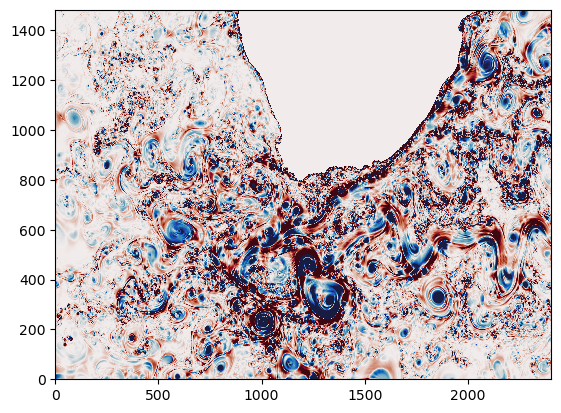

In [8]:
# Let's have a look at the fields
plt.pcolormesh(data_int['OW'].isel(time=0), vmin=-5e-10, vmax=5e-10, cmap=cm.balance)

We see several eddy-like features that have a low OW-parameter, now let's see whether the algorithm detects them as eddies!

# DETECTION

Things to note for the setting of `detection_parameters`:  
1. `'lon1'` and `'lon2'` need to be in the range (-180, 180). `'lon2'` can be smaller than `'lon1'` if you want to extract work in a region extending across the dateline (e.g. `'lon1': 160`, `'lon2': -170`). 
2. `'OW_thr': data_int` if the field `OW_std` in `data_int` is 2D, i.e. we have a spatially varying standard deviation of the Okubo-Weiss parameter. `'OW_thr': data_int['OW_std'].values` if the field `OW_std` in `data_int` is 1D.  
3. `'OW_thr_factor'` is usually chosen in the range `(-0.5, -0.2)` ([Chelton et al., 2007](https://doi.org/10.1029/2007GL030812); [Isern-Fontanet et al., 2003](https://doi.org/10.1175/1520-0426(2003)20<772:IOMEFA>2.0.CO;2)).

In [9]:
# Specify parameters for eddy detection
detection_parameters = {'model': 'ORCA',
                        'grid': 'latlon',
                        'start_time': datestart, # time range start
                        'end_time': dateend, # time range end
                        'calendar': 'standard', # calendar, must be either 360_day or standard
                        'lon1': 0, # minimum longitude of detection region
                        'lon2': 40, # maximum longitude
                        'lat1': -45, # minimum latitude
                        'lat2': -25, # maximum latitude
                        'min_dep': 0.5, # minimum ocean depth where to look for eddies in m, masking out areas shallower than value
                        'res': 1./60., # resolution of the fields in degree
                        'OW_thr': data_int['OW_std'].values, # 
                        'OW_thr_name': 'OW_std', # Okubo-Weiss threshold for eddy detection
                        'OW_thr_factor': OW_thr_factor, # Okubo-Weiss parameter threshold
                        'Npix_min': Npix_min, # minimum number of pixels (grid cells) to be considered as eddy
                        'Npix_max': Npix_max, # maximum number of pixels (grid cells)
                        'no_long': False, # If True, elongated shapes will not be considered
                        'no_two': False # If True, eddies with two minima in the OW
                                        # parameter and a OW > OW_thr in between  will not
                                        # be considered
                       }

Note that, when regridding was forced to be avoided in the interpolation (`avoid_regrid = True`), it will not work (yet) with `et.detection.detect_SSH`. Only detection based on the Okubo-Weiss parameter will work with the `avoid_regrid = True` option.  

### Parallel detection
There are two ways to parallelize the detection (if the necessary packages are installed.)  
   1. [**dask_bags** ](https://docs.dask.org/en/stable/bag.html). To use `dask_bags`, simply set the argument `use_bags=True` in the call to `et.detection.detect_OW()`.  
   2. [**multiprocessing**](https://docs.python.org/3/library/multiprocessing.html). To use `multiprocessing`, set argument `use_mp=True` in the call to `et.detection.detect_OW()` and specify how many CPUs to use by setting `mp_cpu=N`, with `N` being an integer.  
   
Note that `dask_bags` also uses `multiprocessing` under the hood. In most cases using `multiprocessing` directly will be faster, but tests should be conducted for each operating system and/or dataset.

In [10]:
# We detect eddies at level XX (as we only calculated the Okubo-Weiss parameter at this level)
eddies = et.detection.detect_OW(data_int.isel(z=depth_index), detection_parameters, 'OW', 'vort', regrid_avoided=False, 
                                 use_bags=False, use_mp=True,mp_cpu=12)

preparing data for eddy detection (masking and region extracting etc.)
Detecting eddies in Okubo-Weiss parameter fields


In [11]:
# In this format, information for every detected eddy is stored
# (eddies[t][ed], where t is the time step and ed the eddy number)
eddies[0][0]

{'time': numpy.datetime64('2012-05-30T12:00:00.000000000'),
 'lon': array([20.97216071]),
 'lat': array([-44.84053881]),
 'amp': array([1.8007691e-05]),
 'eddy_j': array([ 1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
         2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
         2,  2,  2,  2,  2,  2,  2,  2,  2,  3,  3,  3,  3,  3,  3,  3,  3,
         3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
         3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  4,  4,  4,
         4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
         4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
         4,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
         5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
         5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
         6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
 

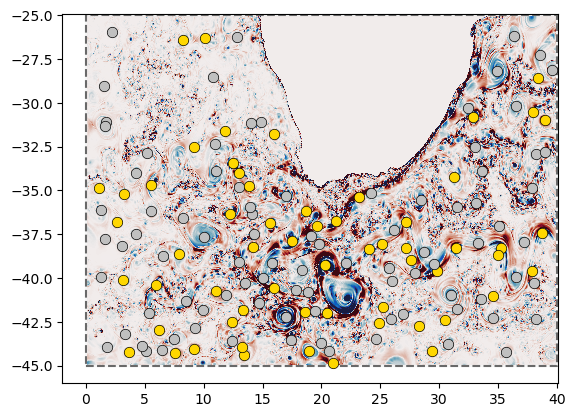

In [12]:
# Plot a single time step to see what the detection method detected
t=0
d_p = detection_parameters
plot_lon = data_int['lon'].where(data_int['lon'].values > 0, other=data_int['lon'].values + 360)
plt.pcolormesh(plot_lon, data_int['lat'].values, data_int.OW.isel(time=t).values,
               vmin=-1e-9, vmax=1e-9, cmap=cm.balance, shading='auto')
for c, l in zip(['whitesmoke', 'dimgray'], ['-', '--']):
    plt.plot([d_p['lon1'], d_p['lon2'], d_p['lon2'], d_p['lon1'], d_p['lon1']],
             [d_p['lat1'], d_p['lat1'], d_p['lat2'], d_p['lat2'], d_p['lat1']],
             color=c, linestyle=l)

for i in np.arange(0, len(eddies[t])):
    if eddies[t][i]['lon'] < 0:
        eddy_lon = eddies[t][i]['lon'] + 360
    else:
        eddy_lon = eddies[t][i]['lon']
    if eddies[t][i]['type'] == 'cyclonic':
        for s, c in zip([7, 6], ['k', 'gold']):
            plt.plot(eddy_lon, eddies[t][i]['lat'], marker='o', color=c, markersize=s)
    elif eddies[t][i]['type'] == 'anticyclonic':
        for s, c in zip([7, 6], ['k', 'silver']):
            plt.plot(eddy_lon, eddies[t][i]['lat'], marker='o', color=c, markersize=s)

We see that all features below a certain OW threshold have been detected. Some of them, we might not consider as an eddy. If you have the feeling, that too many features are detected, that are not eddies, change parameters like `OW_thr_factor`, `Npix_min`, `Npix_max`

In [13]:
# For every time step, we store one file on disk with all the information of the detected
# eddies at this time step
for i in np.arange(0, len(eddies)):
    datestring = str(eddies[i][0]['time'])[0:10] #[0:13] YYYY-MM-DDTHH, e.g. 2012-06-30T02 for 2am at 30 June 2012
    with open(outpath + f'{data_resolution}/depth-{depth}/' + 'test_'
          + str(datestring) + f'_eddies_OW{np.abs(OW_thr_factor)}_Npix-{Npix_min}-{Npix_max}_depth-{depth}m_test.pickle', 'wb') as f:
        pickle.dump(eddies[i], f, pickle.HIGHEST_PROTOCOL)
    f.close()

In [14]:
end_time = time.time()

execution_time = end_time - start_time
hours = int(execution_time // 3600)
minutes = int((execution_time % 3600) // 60)
seconds = int(execution_time % 60)

print(f"Execution time: {hours:02}:{minutes:02}:{seconds:02}")

Execution time: 00:20:15


---
---
---
---
---
---
---

# TRACKING

Things to note for the setting of `tracking_parameters`:  
1. `'start_time'` is required to be no earlier than the earliest actual date of the detected eddies. In our case here, for the year 0002 and a 5-day temporal resolution of the data, this is `'0002-01-05'` (The `MITgcm` stores the 5-daily averages at the end of the 5-day period).
2. `'lon1'` and `'lon2'` need to be identical to `'lon1'` and `'lon2'` in `detection_parameters`.  
3. If you stored the detected eddies in files and want to track these, set `'dict': 0`, make sure `'data_path'`, `'file_root'` and `'file_spec'` are set accordingly and use `in_file=True` as an argument to `et.tracking.track()`.. The method will look for files `datapath + file_root + 'YYYYMMDD' + file_spec + '.pickle'`, the date `'YYYYMMDD'` is automatically calculated from `'start_time'`, `'dt'`, and `'end_time'`. You have to make sure that the stored, detected eddies contain that date in their filename (e.g. as defined in the cell above)!  

Some notes on the search distance `search_dist` that is used to determine in what radius to look for a similar eddy at the next time step.  
    - If `search_circle: True`, the algorithm simply searches for similar eddies within a radius of `search_dist` kilometers around the center of the current eddy. This is the simplest method.
    - If `search_circle: False`, the algorithm will determine where to look for similar eddies based on an ellipse with a minor axis of `search_dist` kilometers. If `search_dist: 0`, the minor and major axes of the ellipse are calculated based on the propagation of Rossby waves to account for the fact that eddies will move towards the West (see [Chelton et al., 2011](https://www.sciencedirect.com/science/article/pii/S0079661111000036) for details). In regions with strong currents this might lead to a loss of a lot of tracks, but no sensitivity studies have been conducted... 

We now have tracked all eddies that met the criteria specified in `tracking_parameters`. Every entry `i` in `tracks[i]` corresponds to one complete track.

### Split up the tracking
If detecting and tracking in larger regions, the tracking can take very long. Because computations are often limited in duration on high-performance computing clusters, an option to split up the tracking into several chunks has been added. Note that the tracking still needs to be done serially, one chunk after the other.

We first track the first half of the month, using the function `split_track()`.

The file `tmp_split1` contains the tracks for the first time span as if they were tracked with `track()`. `tracks_split` additionally contains all unfinished tracks and needs to be passed on to the next round of tracking. `terminated1` contains all tracks that have been already terminated and needs to passed on to the next round as well to make sure they don't get tracked again.

The variable `tracks_from_split` now contains the same tracks as the variable `tracks` from the normal tracking function `track()`. `tracks_split2` and `terminated2` are only needed when another period of tracking is to be added.

### SAMPLING

Things to note for the setting of `sample_parameters`:  
1. `'start_time'` is required to be no earlier than the earliest actual date of the tracked eddies. In our case here, for the year 1976 and a 5-day temporal resolution of the data, this is `'1976-01-03'` (if we had daily data, it would be `'1976-01-01'`).
2. `'lon1'` and `'lon2'` need to be identical to `'lon1'` and `'lon2'` in `detection_parameters`.  
3. Right now, the usage of `'range'` and `'split'` has not been thouroughly tested! It seems to work for most cases though.  

`'range'`: Set to `True` if you only want to sample eddies within a certain range `'values_range'` of a property `'var_range'` in the dataset `'ds_range'`. `'var_range'` needs to be 2D (thus the `.isel(z=9)` in the example below) and interpolated to the same grid as `OW` used above. It is most likely that, if you follow this example, `'var_range'` is stored in the same dataset as `OW`. In the example below, only eddies that have a center temperature between 4 and 7 degrees C at depth level 10 (`z=9`) will be sampled and stored.  

`'split'`: Set to `True` if you want to split the sampled eddies into two categories, above and below a certain threshold value `'value_split'` of a variable `'var_split'` in the dataset `'ds_split'`. As for `'range'`, `'var_split'` needs to be 2D and interpolated to the same grid as `OW` used above. In the example below the eddies will be put into two categories: In the first category, the eddies must have a center surface salinity above 34.0 and in the second category, below 34.0.

The sampling can take quite long as for every eddy that fits the criteria we need to read data from disk at every time step  
The names of the files will be defined by `save_name`, the criteria you specify and the eddy number  
For this sampling parameters, the file name of the first eddy will be  
`test.anticyclonic.larger_25.longer_5.0000001.nc`  

If you set `'split'` to `True`, the file names will differ for the two categories.  
`test.anticyclonic.larger_25.longer_5.0000001.above_thr.nc` for eddies that are above `'value_split'`  
`test.anticyclonic.larger_25.longer_5.0000001.below_thr.nc`
for eddies that are below `'value_split'`.

# AVERAGING

We can now average over the sampled eddies.  
As each eddy has its own file, we first need to find out how many files/samples there are, so we can loop over them and then store the datasets in a dictionary.  
Note that for large region, i.e. a lot of samples the resulting dataset could be too large to fit into memory. The `chunks={}` argument to `xr.open_dataset()` is an attempt to overcome this, however I do not know yet whether this has a lot of effect! One could also split the samples into several parts and then work on each part seperately (the number of eddies going into each average is stored, so one could later do a weighted average over the different parts!)

First a "preparation" is performed: Basically, all eddies are interpolated onto a normalized (in length) section crossing them through the eddy center. This section's orientation can be defined by the argument `section`, which can be either `'zonal'` (default) or `'meridional'`. The length of this section can be defined with argument `interp_vec`. A larger number gives a finer resolution of the interpolated data, but might not necessarily be useful (if input data is coarser resolution for example).    
For every variable specified, at every time step, the values and anomalies (with respect to surroundings) are interpolated (with method `method`) onto the normalized section and stored according to the month the eddy was first detected. The depth profile of the surroundings is stored as well.  
For available interpolation methods please have a look in the documentation of the underlying function [`scipy.interpolate.interp1d`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interp1d.html).

Here for example, 5 eddies originating in July have been stored with a maximum length of 37 time steps. 11 is the length of the depth dimension, 41 the length of the normalized section.

Next we can average these samples in different ways.  
Three possibilities are given with `average`  
1. seasonal -> bins the samples (of all available years) into four seasons (DJF, MAM, JJA, SON) and averages them into a seasonal climatology  
2. monthly  -> does the same for each month (so you end up with a monthly climatology)  
3. total    -> averages over all available eddies  
The three methods all return the means, standard deviations (across eddies), and the number of eddies that went into the derived quantities for a) the variables specified, b) their anomalies to the surroundings, c) the surroundings. These results are stored in the output dictionary under `output['ave']['mean'][period]['variable']`, `output['ave']['mean'][period]['variable_anom']`, `output['ave']['mean'][period]['variable_around']`, respectively. `period` refers to 1. `DJF`, `MAM`, `JJA` or `SON`, 2. `01`, `02`, `03`, etc., representing the month, or in case of the total average thie layer in the dictionary does not exist.  
Additionally, the averaged temporal evolution of the eddy centers will be stored under `output['evo'][...]`.